# Organization Network Analysis

This experiment will create an organization influence graph using a research data published in 2004. 


Workflow:
    1. Load dataset
    2. Compute centrality eigenvalue of each node for influence score
    3. Plot 2D graph using NetworkX
    4. Plot 3D interactive graph using igraph and Plotly

In [323]:
import igraph
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

## Load Data
[Dataset](https://toreopsahl.com/datasets/#Cross_Parker) used in this analysis was first published by Cross and Parker in 2004 [1] and it has survey results from 46 employees. 

Survey question: 

“Please indicate how often you have turned to this person for information or advice on work-related topics in the past three months”. 

0: I Do Not Know This Person; 1: Never; 2: Seldom; 3: Sometimes; 4: Often; and 5:Very Often.

[1] [Cross, R., Parker, A., 2004. The Hidden Power of Social Networks. Harvard Business School Press, Boston, MA.](https://www.bu.ac.th/knowledgecenter/epaper/jan_june2010/pdf/Page_155.pdf)

In [340]:
# Read in sample dataset
data_network = pd.read_csv('data\Cross_Parker-Consulting_info.txt', sep=' ')
data_network.head(5)

,e1,e2,score
0,1,3,5
1,1,8,3
2,1,9,3
3,1,12,3
4,1,15,2


## Create network graph using NetworkX

[NetworkX](https://networkx.github.io/) is a Python package for studying structure, dynamics, and functions of complex networks.

Our employee influence network is a direct graph, i.e. an arrow line from employee e1 to e2 means that e1 has some "influence" on e2.

In [339]:
# Create network graph using NetworkX
G = nx.from_pandas_edgelist(data_network, source = 'e1', target = 'e2', 
                                 edge_attr = 'score',create_using = nx.DiGraph())
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 46
Number of edges: 879
Average in degree:  19.1087
Average out degree:  19.1087


There are many ways to compute centrality scores e.g. Degree Centrality (for popularity), Closeness Centrality (for centralness), and Betweenness Centrality (for bridge). We use the Eigenvector Centrality which measures node **influence** in the graph. Note, scores from the data sample are used to compute a weighted adjacency matrix, instead of simple 0s and 1s.

In [341]:
# Compute weighted eigenvector centrality
centrality_nx = nx.eigenvector_centrality(G, weight='score')

In [344]:
# Find the largest node in the graph that has the largest centrality value (employee that has the biggest influence in the org)
(largest_hub, degree) = sorted(centrality_nx, key=centrality_nx.get, reverse=True)[:2]
largest_hub

6

Let's plot the graph. Red node (#6) represents the employee who has the most influence in the org. Influence power of the others is reflected by the size of the node. Edge color shows influence score (1 to 5) of one employee on another. 

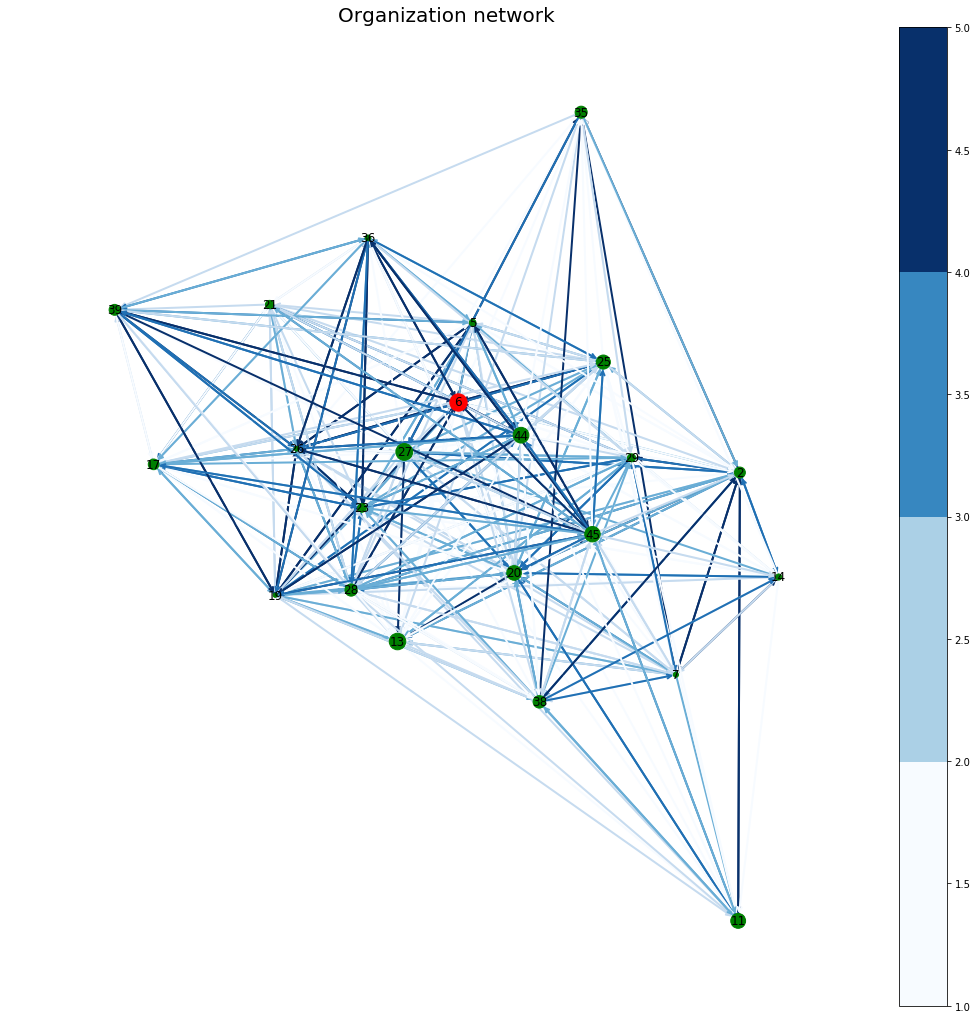

In [351]:
# Create ego graph of main hub
hub_ego = nx.ego_graph(G, largest_hub)
pos = nx.spring_layout(hub_ego)
edge_colors = [d['score'] for (u, v, d) in hub_ego.edges(data=True)]
node_sizes =  [v * 1000 for v in centrality_nx.values()]
plt.figure(figsize=(18,18))
# Draw nodes
nodes = nx.draw_networkx_nodes(hub_ego, pos, with_labels=True, node_size=node_sizes, node_color='green')
# Draw edges
edges = nx.draw_networkx_edges(hub_ego, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors, 
                               edge_cmap=plt.cm.Blues, width=2)
# Draw ego as large and red
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], node_size=300, node_color='r')
# Draw labels
labels = nx.draw_networkx_labels(hub_ego, pos)
# Add a color map for edges
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.get_cmap('Blues', 4))
pc.set_array(edge_colors)
plt.colorbar(pc)
ax = plt.gca()
plt.title("Organization network", fontsize=20)
plt.axis('off')
plt.show()

## Create interactive 3D graph using igraph + plotly

In [358]:
# Create a weighted direct graph using igraph
G = igraph.Graph.TupleList(data_network.itertuples(index=False), weights=True, directed=True)
igraph.summary (G)

IGRAPH DNW- 46 879 -- 
+ attr: name (v), weight (e)


In [359]:
# Number of vertices/nodes
N = G.vcount()

In [360]:
# List of all edges
Edges = G.get_edgelist()

In [363]:
# Compute weighted eigenvector centrality
centrality = dict(zip(G.vs['name'], G.eigenvector_centrality(weights='weight')))
print(sorted(centrality, key=centrality.get, reverse=True))

[6, 26, 45, 19, 20, 44, 28, 23, 2, 36, 25, 29, 5, 39, 17, 38, 13, 7, 11, 27, 8, 18, 14, 35, 21, 34, 31, 33, 22, 1, 4, 12, 10, 41, 40, 9, 32, 37, 43, 16, 15, 42, 3, 46, 24, 30]


D:\Anaconda\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

Weighted directed graph in eigenvector centrality at src\centrality.c:362



In [364]:
# Get node sizes, labels, and scores
nodes_size = [v * 100 for v in centrality.values()] 
labels = list(centrality.keys()) #G.vs['name']
scores = list(data_network['score'])

In [370]:
# Kamada-Kawai graph layout
layt=G.layout('kk', dim=3) 

The following code is borrowed from https://plot.ly/python/3d-network-graph/

In [366]:
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]  
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]  

In [381]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(width=2, color=scores, colorscale='Blues'),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=nodes_size,
                             #color=nodes_size,
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )

axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="Organization network (3D visualization) <br> (Interactive and Zoomable)",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text="Posted article: <a href='https://ai-journey.com/2019/04/organizational-network-analysis'>Organizational network analysis</a>"
               + "<br>Data source: <a href='https://toreopsahl.com/datasets/#Cross_Parker'>Cross_Parker-Consulting_info.txt</a>",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ],    )

In [382]:
# To run the graph offline, remove the comment sign from the next two lines
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)
# To run the graph offline, remove the comment sign from the next line
iplot(fig, filename='ona_analysis')
# To run the graph offline, comment out the next line
# py.plot(fig, filename='ona_analysis')